![Xilinx Logo](images/xilinx_logo.png "Xilinx Logo")

# 1. Introduction:

This notebook demonstrates -
1. Loading of shell and accelerators using DFX Daemon.
2. DFX manager Daemon enables different run time orchestrations including XRT & native app runtime. 
3. Use of DPU and Preprocessing Accelerators to perform AI Inference on video input. 
4. Option to run different AI models like facedetect, refinedet, and SSD using the same set of accelerators.

# 2. Shell Design

To support the video application, the VCU has been added to the shell. PL region of one slot has been transferred to the static shell for VCU integration.

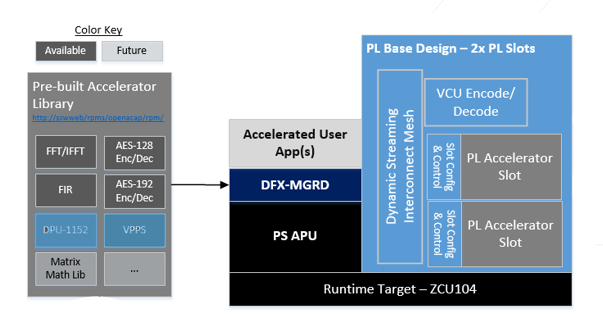

In [22]:
from IPython.display import Image
Image(filename='./images/2rpdesign.png')

Import the required python modules

In [23]:
from dfxdGraph import Graph, video_pipeline
import numpy as np
import IPython
from IPython.display import *
import ipywidgets as widgets
from ipywidgets import *
import plinfo
import time
! modetest -D fd4a0000.zynqmp-display -w 40:g_alpha_en:0

trying to open device 'i915'...done


# 3. Video Pipeline

Pipeline flow-
1. The VCU decode the H264 file to NV12 format.
2. The preprocessing block resizes, quantizes, and converts to BGR format.
3. DPU does the AI inference based on the model selected and generates bounding box data. 
4. Meta Affixer scales the bounding box data recieved wrt the resolution of vcu decoded output.
5. The bounding box draws the results around the objects of interest.

PL - Pre-proc, DPU 

Hardened Block - VCU Dec, Display Port

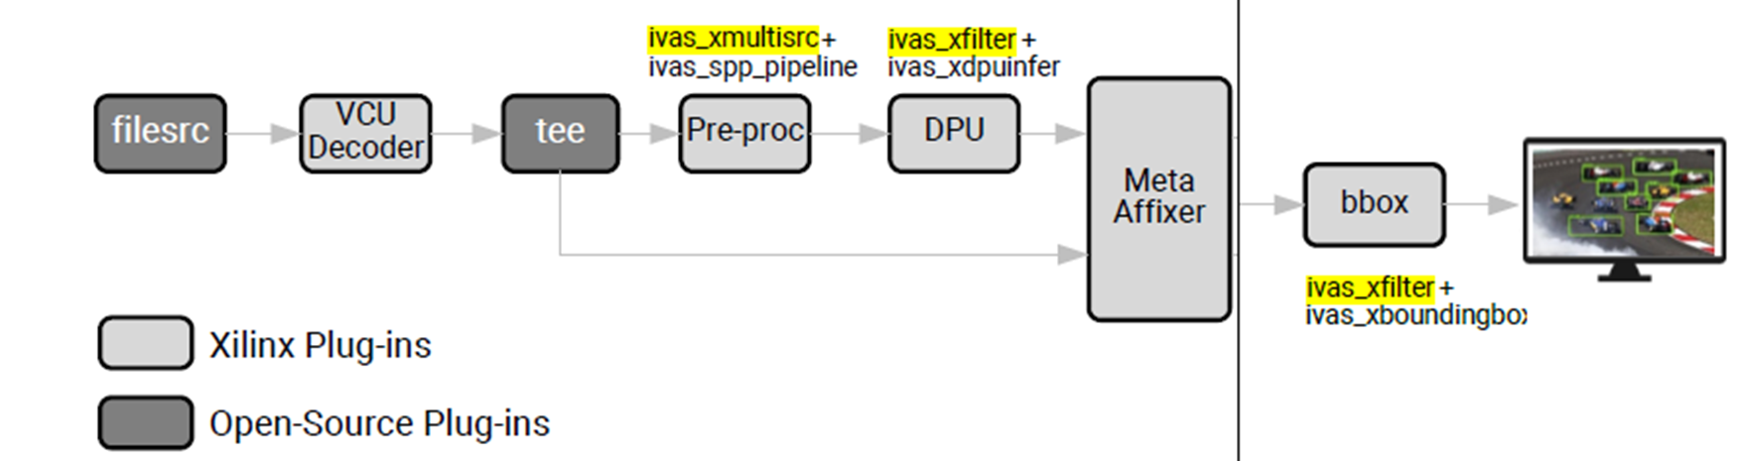

In [24]:
from IPython.display import Image
Image(filename='./images/demo.png')

# 4. Use DFXD daemon to load Accelerators

In [25]:
graph = Graph()
dpuNode = graph.addAcceleratorNode("DPU_1152_2RP")
PPNode = graph.addAcceleratorNode("pp_pipeline_2RP")

* Data exchange via graph

In [26]:
accelNode = video_pipeline(graph)

# 5. Choose AI Inference model

* Choose the required AI model 

In [27]:
aitask= [ "refinedet","facedetect","ssd" ] 

In [28]:
w = widgets.Dropdown(options=aitask,value=aitask[0],description='ai_task :',)
ai_task = aitask[0]
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global ai_task 
        ai_task = change['new']
w.observe(on_change)
display(w)

Dropdown(description='ai_task :', options=('refinedet', 'facedetect', 'ssd'), value='refinedet')

* Running Input Sample Video

In [29]:
if ai_task == 'ssd':
    src = './video_samples/Road-Adas.nv12.30fps.1080p.h264'
else:
    src = './video_samples/walking-people.nv12.30fps.1080p.h264'

In [30]:
! gst-launch-1.0 filesrc location={src} ! h264parse ! omxh264dec !  tee name=t0 t0.src_0 !  queue !  kmssink bus-id=fd4a0000.zynqmp-display  sync=false fullscreen-overlay=true > /dev/null 2>&1

# 6. Run AI Inference 

In [32]:
confdir="/usr/share/ivas/"+ ai_task

Pipeline running on Input file-

gst-launch-1.0 filesrc location={src} ! h264parse ! omxh264dec !  tee name=t0 t0.src_0 !  queue ! ivas_xmultisrc kconfig="{confdir}/preprocess.json" ! ivas_xfilter kernels-config="{confdir}/aiinference.json" ! scalem0.sink_master ivas_xmetaaffixer name=scalem0 scalem0.src_master ! fakesink  t0.src_1 ! scalem0.sink_slave_0 scalem0.src_slave_0 ! queue !   perf ! ivas_xfilter kernels-config="{confdir}/drawresult.json" ! kmssink bus-id=fd4a0000.zynqmp-display  sync=false fullscreen-overlay=true 

In [33]:
! gst-launch-1.0 filesrc location={src} ! h264parse ! omxh264dec !  tee name=t0 t0.src_0 !  queue ! ivas_xmultisrc kconfig="{confdir}/preprocess.json" ! ivas_xfilter kernels-config="{confdir}/aiinference.json" ! scalem0.sink_master ivas_xmetaaffixer name=scalem0 scalem0.src_master ! fakesink  t0.src_1 ! scalem0.sink_slave_0 scalem0.src_slave_0 ! queue !   perf ! ivas_xfilter kernels-config="{confdir}/drawresult.json" ! kmssink bus-id=fd4a0000.zynqmp-display  sync=false fullscreen-overlay=true > /dev/null 2>&1

# 7. Unload Accelerators

Reset mechanism for zocl

In [34]:
! xbutil program -p /usr/bin/dummy.xclbin

INFO: Found total 1 card(s), 1 are usable
INFO: xbutil program succeeded.


Unload DPU & pp_pipeline Accelerators

In [35]:
accelNode.remove()

<center>Copyright© 2021 Xilinx</center>